# CRIES
### Counting Reads for Intronic and Exonic Segments
https://github.com/csglab/CRIES


**Step 1. Creating GTF annotation files**

Intron and exon annotations for `gencode.v34` made within my notebook named `build-genome.ipynb`. 

**Step 2. Mapping reads**

`STAR` 

**Step 3. Counting reads that map to intronic or exonic segments of each gene**

`featureCounts`
http://bioinf.wehi.edu.au/featureCounts/

In [35]:
cat _sh/loop_featureCounts.sh

#!/usr/bin/env bash
#loop featureCounts intron and exon counts

set -o errexit
set -o nounset
set -o xtrace

bam_folder='/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-bam'
stbl_folder='/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl'
GTF_index='/rumi/shams/genomes/hg38/hg38_ensemble_'

main() {
  local f
  for f in ${bam_folder}/*.bam; do
    base=`basename $f`
    sample=${base/.bam/};
    echo -e '----------------------- ' $sample  ' -----------------------'
    featureCounts -M -T 18 -t intron -g gene_id -a ${GTF_index}introns.gtf -o ${stbl_folder}/counts/${sample}_introns.txt ${f}
    featureCounts -M -T 18 -t exon -g gene_id -a ${GTF_index}consExons.gtf -o ${stbl_folder}/counts/${sample}_exons.txt ${f}
  done
}

mkdir -p $stbl_folder
mkdir -p ${stbl_folder}/counts

main


In [8]:
!multiqc counts/*_exons.txt.summary -f -n counts-exons-multiqc.html
!multiqc counts/*_introns.txt.summary -f -n counts-introns-multiqc.html

[INFO   ]         multiqc : This is MultiQC v1.9
[INFO   ]         multiqc : Template    : default
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/120h_DMSO_rep1_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/120h_DMSO_rep2_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/120h_treated_rep1_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/120h_treated_rep2_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/6h_DMSO_rep1_exons.txt.summary
[INFO   ]         multiqc : Searching   : /rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl/counts/6h_DMSO_rep2_exons.txt.summary
[INFO   ]  

In [ ]:
import os
import subprocess
import glob
import warnings
import pandas as pd
import numpy as np

from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=RRuntimeWarning)

**Step 4. Normalization** - REMBRANDTS

#### REMoving Bias from Rna-seq ANalysis of Differential Transcript Stability
[REMBRANDTS](https://github.com/csglab/REMBRANDTS) is a package for analysis of RNA-seq data across multiple samples in order to obtain unbiased estimates of differential mRNA stability. It uses DESeq to obtain estimates of differential pre-mRNA and mature mRNA abundance across samples, and then estimates a gene-specific bias function that is then subtracted from Δexon–Δintron to provide unbiased differential mRNA stability measures.



In [8]:
stbldir = '/rumi/shams/abe/Gilbertlab/Decitabine_treatment/RNA-seq/hl60-stbl'

# list path to intron and exon count files 
exon_count_files = glob.glob(f'{stbldir}/counts/*_exons.txt')
intron_count_files = glob.glob(f'{stbldir}/counts/*_introns.txt')

# define gene_ids for each count results for exon and intron 
exon_gene_ids = pd.read_table(exon_count_files[0], skiprows=1)['Geneid'].tolist()
intron_gene_ids = pd.read_table(intron_count_files[0], skiprows=1)['Geneid'].tolist()

# read all count tables into one dataframe 
df_exon = pd.DataFrame({}, index=exon_gene_ids)
df_intron = pd.DataFrame({}, index=intron_gene_ids)

for f in exon_count_files:
    counts = pd.read_table(f, skiprows=1).iloc[:, -1].tolist()
    f_n = f.split('/')[-1].replace('_exons.txt', '')
    df_exon[f_n] = counts
for f in intron_count_files:
    counts = pd.read_table(f, skiprows=1).iloc[:, -1].tolist()
    f_n = f.split('/')[-1].replace('_introns.txt', '')
    df_intron[f_n] = counts

samples = ['6h_DMSO_rep1', '6h_DMSO_rep2', '6h_treated_rep1', '6h_treated_rep2',
 '72h_DMSO_rep1', '72h_DMSO_rep2', '72h_treated_rep1', '72h_treated_rep2',
 '120h_DMSO_rep1', '120h_DMSO_rep2', '120h_treated_rep1', '120h_treated_rep2']
# reorder in to same column order as the meta table rows 
df_exon = df_exon[samples] 
df_intron = df_intron[samples] 

In [9]:
# select overlap gene_ids
overlaps = list(set(df_exon.index)&set(df_intron.index))
# subset by overlap gene_ids 
df_exon = df_exon.loc[overlaps, ]
df_intron = df_intron.loc[overlaps, ]

# write input counts 
for c in samples:
    df_exon.loc[:, c].to_csv(f'{stbldir}/counts/{c}_exons.ol.txt', sep='\t', header=None)    
    df_intron.loc[:, c].to_csv(f'{stbldir}/counts/{c}_introns.ol.txt', sep='\t', header=None)

### Prepare REMBRANDTS inputs
# make meta data for running REMBRANDTS
labels = np.repeat(df_exon.columns.tolist(), 2)
files = [f'{labels[i]}_exons.ol.txt' if i%2==0 else f'{labels[i]}_introns.ol.txt' for i in range(len(labels))]
readtypes = ['exonic' if i%2==0 else 'intronic' for i in range(len(labels))]
meta = pd.DataFrame({'Label':labels, 'File':files, 'ReadType':readtypes, 'Batch':1})
meta.to_csv(f'{stbldir}/input_table.txt', index=False, sep='\t')

Run REMBRANDTS


In [10]:
os.chdir('/rumi/shams/abe/Workflows/REMBRANDTS/')
cmd = f'bash REMBRANDTS.sh Decitabine_treatment {stbldir}/input_table.txt {stbldir}/counts/ 0.99 linear'
subprocess.call(cmd , shell=True)

subprocess.call(f'rm -rv {stbldir}/output', shell=True)
subprocess.call(f'mv -v ./out/Decitabine_treatment/ {stbldir}/output', shell=True)
os.chdir(stbldir)

# clean results 
out = pd.read_table(f'{stbldir}/output/stability.filtered.mx.txt', index_col=0)
out.columns = [i.replace('.x','').replace('.','-')[1:] for i in out.columns]
out.columns
out.to_csv(f'{stbldir}/REMBRANDTS.txt', sep='\t')
print('\n********************************** Finished **********************************\n')


********************************** Finished **********************************



# Differential stability 
`Limma` is originally design for micro-array experiments which is mainly doing same task as `DESeq2`.  Comparing to RNA expression analysis, RNA stability may have negetive values; `DESeq2` does not support negetive values but `Limma` does. Therefore, we decided to use `Limma` package instead of `DESeq2` for differential analysis. 

I've learned how to use limma from this [DataCamp course | differential-expression-analysis-with-limma-in-r](https://campus.datacamp.com/courses/differential-expression-analysis-with-limma-in-r/). 
However, I found these links useful while browsing. 
- http://genomicsclass.github.io/book/pages/using_limma.html
- https://www.bioconductor.org/packages/devel/workflows/vignettes/RNAseq123/inst/doc/limmaWorkflow.html

In [4]:
%reload_ext rpy2.ipython

In [6]:
%%R
library(edgeR)
library(Biobase)
library(rtracklayer)
library(tidyverse)

Read gene annotations into R 

In [7]:
%%R
GTF = '/rumi/shams/genomes/hg38/hg38_ensemble_genes.gtf'

gtf <- rtracklayer::import(GTF)
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% column_to_rownames('gene_id') %>% dplyr::select('gene_name')

In [8]:
%%R
# meta table
treats  <- rep(c(rep('DMSO',2), rep('treated',2)),3)
reps    <- rep(c('rep1','rep2'),6)
hours   <- c(rep('6h',4),rep('72h',4),rep('120h',4))
hours = factor (hours, levels = c("6h", "72h", "120h"))

samples = paste(hours, treats, reps, sep='_')
group = paste(hours, treats, sep='.')

meta <- data.frame(
    time=factor(hours), 
    cond=factor(treats),
    group=factor(group),
    sample_id=samples,
    row.names=samples)
meta$cond <- relevel(meta$cond, ref='DMSO')
meta$group <- relevel(meta$group, ref='6h.DMSO')
meta$time


 [1] 6h   6h   6h   6h   72h  72h  72h  72h  120h 120h 120h 120h
Levels: 6h 72h 120h


In [9]:
%%R 
# Read `REMBRANDTS` results
counts <- read.table("REMBRANDTS.txt", row.names = 1, stringsAsFactors=FALSE, header=TRUE)
colnames(counts) <- samples

In [10]:
%%R 
# Make annotation dataframe 
ann = data.frame(
    name=gene2name[rownames(counts),],
    row.names=rownames(counts)
)

# Create ExpressionSet object
eset <- ExpressionSet(
    assayData = as.matrix(counts),
    phenoData = AnnotatedDataFrame(meta),
    featureData = AnnotatedDataFrame(ann)
)

In [11]:
%%R 
# Create design matrix
design <- model.matrix(~cond + group, meta)
# Count the number of samples modeled by each coefficient
colSums(design)

      (Intercept)       condtreated    group120h.DMSO group120h.treated 
               12                 6                 2                 2 
  group6h.treated     group72h.DMSO  group72h.treated 
                2                 2                 2 


In [12]:
%%R 
cm = makeContrasts(
    # contrast design: treatment at 120h vs dmso at 120h
    hl60_120h = condtreated + group120h.treated - group120h.DMSO,
#     # contrast design: treatment at 72h vs dmso at 72h
#     hl60_72h = condtreated + group72h.treated - group72h.DMSO,
    # contrast design: treatment at 6h vs dmso at 6h
    hl60_6h = condtreated + group6h.treated,
    levels = design
)

# Fit coefficients 
fit <- lmFit(eset, design)
# Fit contrasts 
fit2 <- contrasts.fit(fit, contrasts = cm)
# Calculate t-statistics 
fit2 <- eBayes(fit2)
# Summarize results 
results <- decideTests(fit2)
print (summary (results))

Coefficients not estimable: group72h.treated 
       hl60_120h hl60_6h
Down           3       0
NotSig      4258    4272
Up            11       0


I don't understand why "Coefficients not estimable: group72h.treated"!

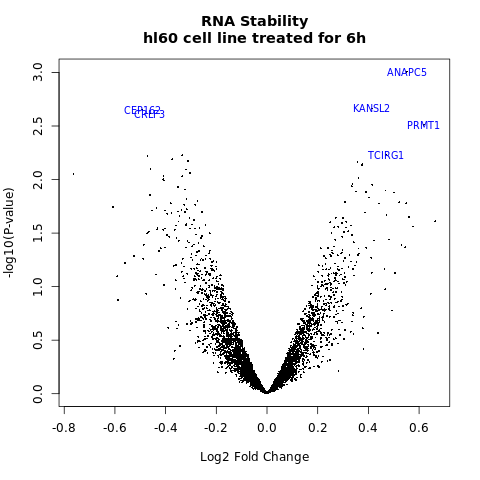

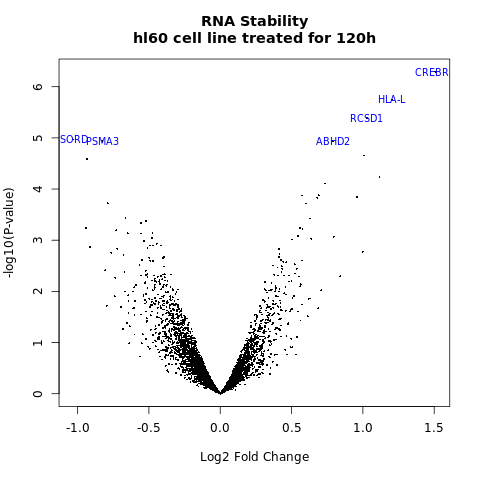

In [13]:
%%R 
volcanoplot(fit2[,'hl60_6h'],highlight = 6, names = fit2$genes[,'name'], main = 'RNA Stability\nhl60 cell line treated for 6h')
volcanoplot(fit2[,'hl60_120h'],highlight = 6, names = fit2$genes[,'name'], main = 'RNA Stability\nhl60 cell line treated for 120h')

Box plot generator for top hits .. 

In [17]:
%%R 
boxplot_top_hit <- function (gene_name){
    gene = (fData(eset) %>% rownames_to_column('row'))$row[fData(eset)$name == gene_name]
    # Create a boxplot of a given gene
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "cond"],main = fData(eset)[gene, "name"])
    boxplot(exprs(eset)[gene, ] ~ pData(eset)[, "time"],main = fData(eset)[gene, "name"])
}


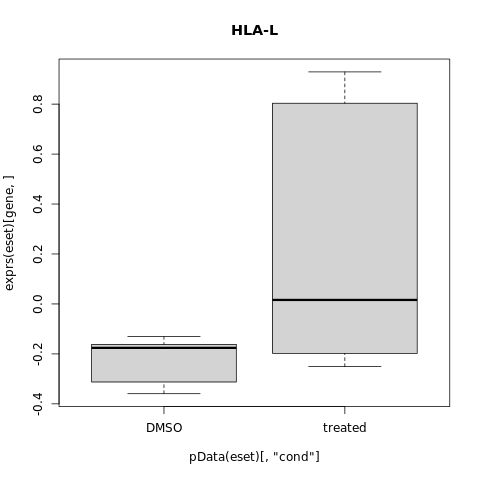

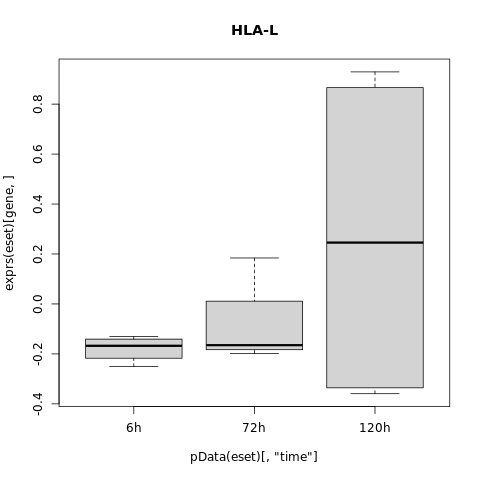

In [18]:
%%R 
boxplot_top_hit('HLA-L')

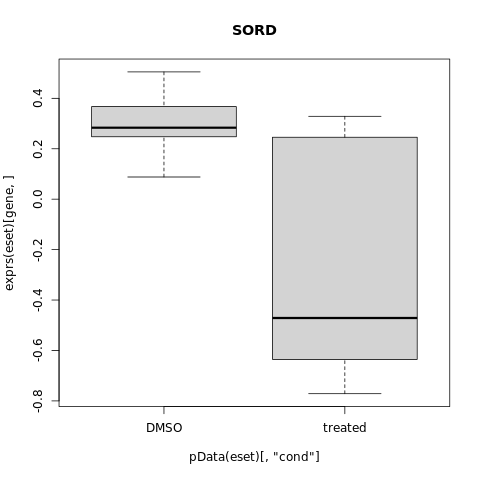

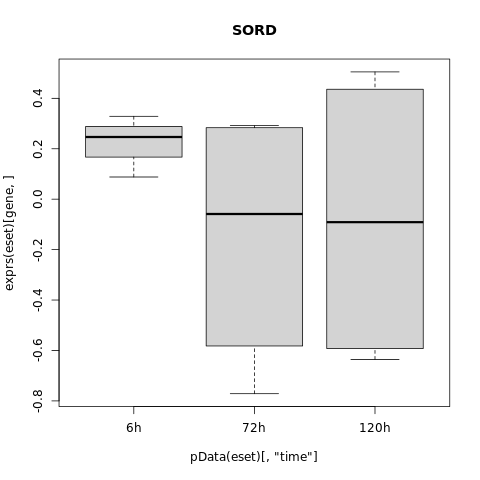

In [19]:
%%R 
boxplot_top_hit('SORD')

## Principal Component Analysis (PCA)
Just like the RNA-seq experssion analysis, sample `72h_treated_rep2` comes up as an outlier. Removing that from the analysis give us a better representation. Therfore, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis.


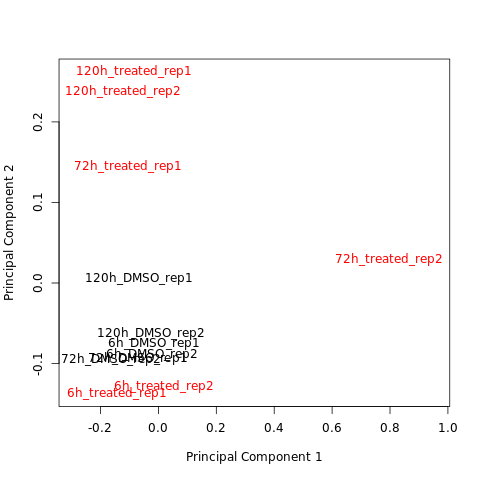

In [47]:
%%R 
# Plot principal components labeled by treatment
col_by_cond=rep(c(rep("black",2), rep("red",2)),3)
plotMDS(eset, labels = pData(eset)[, "sample_id"], col=col_by_cond, gene.selection = "common")

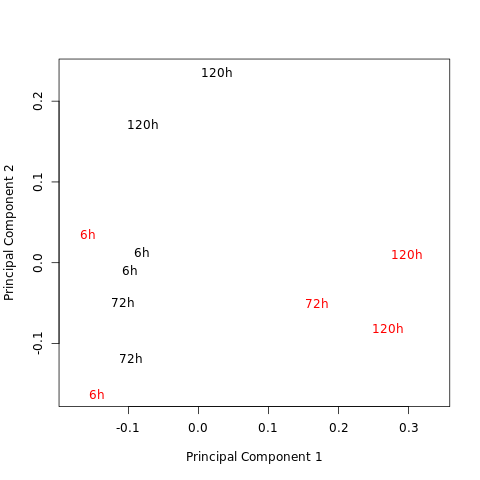

In [46]:
%%R 
# Plot principal components labeled by treatment
filter = !eset@phenoData@data$sample_id == '72h_treated_rep2'
plotMDS(eset[,filter], labels = pData(eset[,filter])[, "time"], col=col_by_cond[filter], gene.selection = "common")

## Normalizing and filtering


In [13]:
%%R 
# Create new ExpressionSet to store normalized data
eset_norm <- eset
# View the distribution of the raw data
# p0 = plotDensities(eset_norm) #, legend = FALSE)

In [14]:
%%R
# Log tranform
exprs(eset_norm) <- log(exprs(eset_norm))
# plotDensities(eset_norm, legend = FALSE)

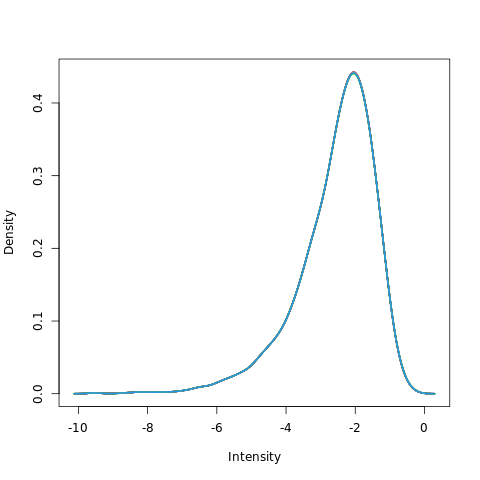

In [15]:
%%R
# Quantile normalize
exprs(eset_norm) <- normalizeBetweenArrays(exprs(eset_norm))
plotDensities(eset_norm, legend = FALSE)

Let's write normalized RNA-Stabilities into a file. 

In [16]:
%%R 
ncu <- exprs(eset_norm) %>% replace_na(0)
write.table(ncu,'hl60_stbl_norm_log_quantile.txt', sep="\t", quote=FALSE, col.names=TRUE)

ncu %>% summary

  6h_DMSO_rep1     6h_DMSO_rep2    6h_treated_rep1  6h_treated_rep2 
 Min.   :-9.527   Min.   :-9.527   Min.   :-9.527   Min.   :-9.527  
 1st Qu.:-2.417   1st Qu.:-2.393   1st Qu.:-2.170   1st Qu.:-2.382  
 Median :-1.231   Median :-1.137   Median : 0.000   Median :-1.098  
 Mean   :-1.372   Mean   :-1.345   Mean   :-1.119   Mean   :-1.335  
 3rd Qu.: 0.000   3rd Qu.: 0.000   3rd Qu.: 0.000   3rd Qu.: 0.000  
 Max.   : 0.000   Max.   : 0.000   Max.   : 0.000   Max.   : 0.000  
 72h_DMSO_rep1    72h_DMSO_rep2    72h_treated_rep1  72h_treated_rep2
 Min.   :-9.527   Min.   :-9.527   Min.   :-9.5268   Min.   :-9.527  
 1st Qu.:-2.230   1st Qu.:-2.301   1st Qu.:-1.9783   1st Qu.:-2.469  
 Median : 0.000   Median : 0.000   Median : 0.0000   Median :-1.389  
 Mean   :-1.175   Mean   :-1.247   Mean   :-0.9717   Mean   :-1.437  
 3rd Qu.: 0.000   3rd Qu.: 0.000   3rd Qu.: 0.0000   3rd Qu.: 0.000  
 Max.   : 0.000   Max.   : 0.000   Max.   : 0.0000   Max.   : 0.000  
 120h_DMSO_rep1   120h_DMSO

what kind of p-value will be the right one to identify differentially expressed genes
https://www.biostars.org/p/18470/

https://support.bioconductor.org/p/7084/

In [21]:
# %%R 
# select_thr <- function (adj){
#     x <- -log10(adj)
#     plot(x, type="l")
#     sigline <- c(.05, .01, .005, .001,.0005, .0001)
#     sigline <- -log10(sigline)
#     sigcolors <- c("red", "blue", "green", "yellow","pink","purple")
#     sapply(1:length(sigline), function(x){abline(h=sigline[x], col=sigcolors[x])})
# }

In [ ]:
# %%R 
# select_thr(stats_120h$adj.P.Val)

In [22]:
# %%R 
# select_thr(stats_6h$adj.P.Val)

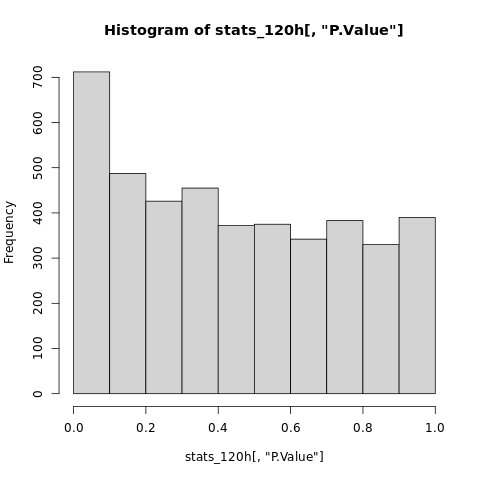

In [18]:
%%R 
# Obtain the summary statistics 
stats_120h <- topTable(fit2, coef = "hl60_120h", adjust.method="fdr", number = nrow(fit2),
                              sort.by = "none")

# Create histograms of the p-values for each contrast
hist(stats_120h[, "P.Value"])

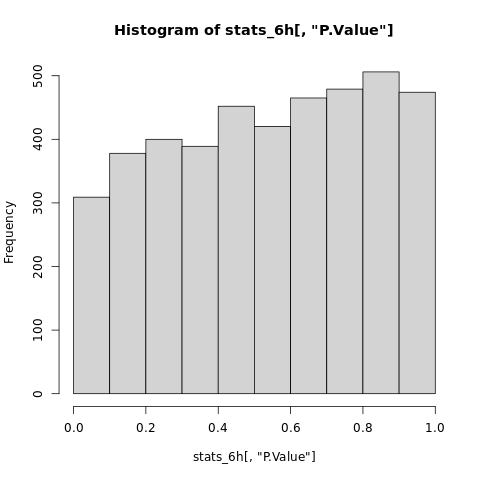

In [19]:
%%R 
# Obtain the summary statistics 
stats_6h <- topTable(fit2, coef = "hl60_6h", number = nrow(fit2),
                              sort.by = "none")

# Create histograms of the p-values for each contrast
hist(stats_6h[, "P.Value"])

# Write result tables into file

Here, I write all results into files which includes log2FC and p.values for contrasts at hour 6 and hour 120, plus gene names and gene ids. 

In [20]:
%%R 
results = data.frame(
    ensembl_id=rownames(fit2$genes),gene_name=fit2$genes$name,
    AveExpr=stats_120h$AveExpr,
    logFC_120h=stats_120h$logFC, P.Value_120h=stats_120h$P.Value, adj.P.Val_120h=stats_120h$adj.P.Val, 
    logFC_6h=stats_6h$logFC, P.Value_6h=stats_6h$P.Value, adj.P.Val_6h=stats_6h$adj.P.Val
)  %>%  remove_rownames  %>% arrange(across(everything(), desc))

# all results 
write.table(results, 
            'hl60_delta_stbl_table.txt', quote = F, col.names=TRUE, row.names=FALSE,sep ='\t')

## Enrichment analysis

Write iGET friendly tables:

In [21]:
%%R 
write.table(results[,c('ensembl_id','logFC_6h')] , '6h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')
write.table(results[,c('ensembl_id','logFC_120h')] , '120h_delta_stbl.txt', 
            quote = F, col.names=FALSE, row.names=FALSE,sep ='\t')



In [59]:
%%bash
ipage=/rumi/shams/abe/Workflows/my_scripts/ipage_human_ensembl.sh 
nohup ls *delta_stbl.txt | parallel -j18 -k bash $ipage {} &> ipage.out &

In [ ]:
# %%R 
# # Extract the entrez gene IDs
# entrez <- rownames(fit2$genes) 
# # Test for enriched KEGG Pathways
# enrich_kegg <- kegga(fit2, geneid = entrez, species = 'Hs')

# # View the top 20 enriched KEGG pathways
# topKEGG(enrich_kegg)

In [ ]:
%%bash
declare -a Comp=('6h' '120h')



for f in `ls -d /flash/bin/iPAGEv1.0/PAGE_DATA/ANNOTATIONS/human_ensembl*`; do
    base=`basename "$f"`
    echo '<table>' >> README.md
    echo '  <tr>' >> README.md
    echo '  <h2>'$base'<h2>' >> README.md
    for C in "${Comp[@]}"; do
        echo '    <td><img src=plots/'${C}'_PAGE_'${base}'.png style="width:600px">' >> README.md
    done
    echo '  <tr>' >> README.md
    echo '<table>' >> README.md
done

## Clustering 

In [60]:
%%R 
df_sig = results %>% 
    filter (
        P.Value_6h     < 0.001 | 
        P.Value_120h   < 0.001 
#         adj.P.Val_6h   < 0.05 |
#         adj.P.Val_120h < 0.05)
           ) %>% 
    remove_rownames %>% column_to_rownames('ensembl_id') 

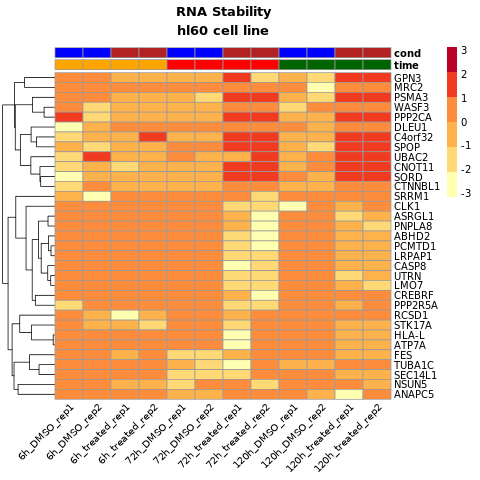

In [66]:
%%R 
library(RColorBrewer)
library(pheatmap)

# Subset normalized counts to significant genes
sig_norm_counts <- ncu[rownames(df_sig), ]


rownames(sig_norm_counts) <- df_sig$gene_name


# Choose heatmap color palette
heat_colors <- brewer.pal(n = 6, name = "YlOrRd")

ann_colors = list(
    cond = c('DMSO'="blue", 'treated'="firebrick"),
    time = c('120h'= "darkgreen", '72h'="red", '6h'="orange")
)

# Plot heatmap
h = pheatmap(sig_norm_counts, 
         color = heat_colors, 
         cluster_cols = F, 
         main = 'RNA Stability\nhl60 cell line',
         cluster_rows = T, 
         show_rownames = T,
         annotation = select(meta, time, cond), 
         scale = 'row', 
         angle_col= 45,
         annotation_legend=F,
         annotation_colors = ann_colors)



In [67]:
%%R 
# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('plots/Heatmap_clustering.pdf', width=7, height=7)
grid::grid.newpage()
grid::grid.draw(h$gtable)
dev.off()

png 
  2 


In [63]:
%%R 
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/limma/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] stats4    parallel  tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] pheatmap_1.0.12      RColorBrewer_1.1-2   forcats_0.5.0       
 [4] stringr_1.4.0        dplyr_1.0.1          purrr_0.3.4         
 [7] readr_1.3.1          tidyr_1.1.1          tibble_3.0.3        
[10] ggplot2_3.3.2        tidyverse_1.3.0      rtracklayer